# Setup

In [1]:
# Obtenção, Tratamento e Processamento dos Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon, MultiPolygon
import alphashape
import altair as alt

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import hdbscan

In [45]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Seleção do Dataset

In [2]:
# Dataset retirado de https://raw.githubusercontent.com/adamlamee/CODINGinK12/master/data/stars.csv
# Créditos em https://github.com/adamlamee/CODINGinK12/blob/master/notebooks/stars.ipynb

Primeiramente, serão definidos parâmetros identificando o nome do arquivo e as colunas a serem importadas para as análises.

In [3]:
dataset_file = "stars.csv"

col_color = "ci"
col_mag = "absmag"
col_temp = "temp"
col_lum = "lum"
col_raio = "radius_est"

A seguir, realizamos o carregamento do dataset escolhido, em formato CSV, e uma exibição do diagrama HR esperado, com base nos dados importados, a fim de identificar possíveis outliers e definir parâmetros para a limpeza.

In [4]:
df = pd.read_csv(dataset_file)

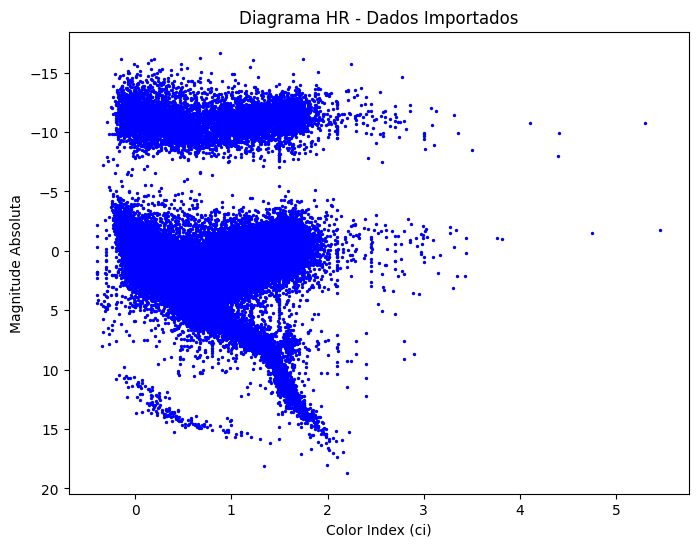

In [5]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Importados")
plt.show()

No diagrama gerado acima, é possível observar uma grande presença de estrelas na faixa de luminosidade absoluta entre -10 e -15. Fisicamente, esses valores não são esperados, pois estrelas deste tipo são extremamente raras. Isso indica possíveis problemas nos dados importados, como vieses para determinados tipos de estrelas ou parâmetros pouco precisos gerando erros numéricos para parte dos dados.

Para identificar possíveis erros, podemos utilizar o método `.describe()` e analisar os resultados obtidos.

In [6]:
df.describe()

,ra,dec,dist,mag,absmag,ci,temp,x,y,z,lum,var_min,var_max
count,119614.000000,119614.000000,119614.000000,119614.000000,119614.000000,117732.000000,117732.000000,119614.000000,119614.000000,119614.000000,1.196140e+05,16991.000000,16991.000000
mean,12.095243,-1.985101,8764.801178,8.429685,0.992129,0.711495,6182.806403,-234.845474,-39.569343,-231.897239,3.544691e+05,9.501848,9.259359
std,6.887589,40.965885,27879.567299,1.427732,4.351890,0.493207,2063.029405,15178.258403,17237.818362,18068.210978,3.333300e+06,1.781001,1.742210
min,0.000000,-89.782428,0.000000,-26.700000,-16.680000,-0.400000,1499.338347,-99950.391270,-99979.246190,-99964.982270,1.230000e-06,-1.333000,-1.523000
25%,6.217463,-36.420663,115.074800,7.650000,0.139000,0.348000,4551.904315,-89.020936,-91.173028,-107.538313,4.746790e+00,8.526000,8.243500
50%,12.127568,-1.639570,213.675200,8.460000,1.495000,0.616000,5905.594297,-1.044429,-1.241516,-3.410872,2.197860e+01,9.849000,9.646000
75%,18.116667,31.519006,390.625000,9.170000,3.159000,1.083000,7169.831570,86.267843,91.846196,94.974160,7.663021e+01,10.707000,10.492000
max,23.998594,89.569427,100000.000000,21.000000,19.629000,5.460000,21707.421710,99982.372690,99996.065510,99862.513670,4.092607e+08,14.902000,13.702000


O primeiro erro notável é em relação às distâncias. O valor máximo para elas está extremamante alto, e medidas astronômicas à tais distâncias podem ser extremamente imprecisas, por possíveis efeitos de nuvens de poeira, erros de fotometria, entre outros. Portanto, a primeira limpeza será a remoção de estrelas com distância acima de 5000.

In [7]:
df = df[df["dist"] < 5000]

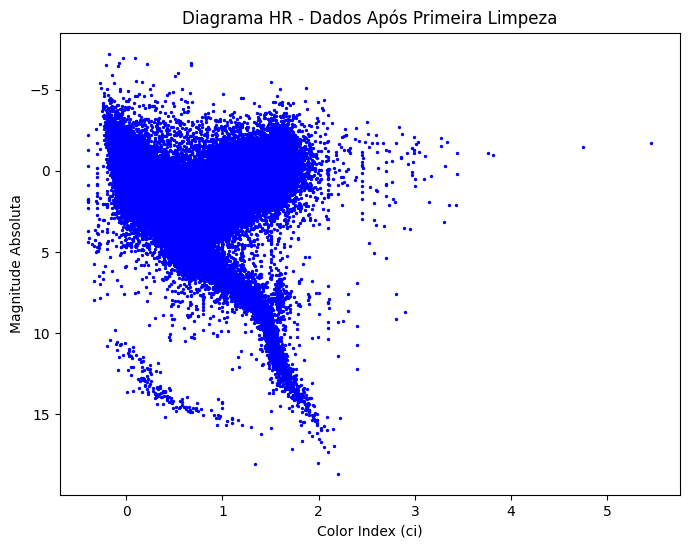

In [8]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Após Primeira Limpeza")
plt.show()

Agora, observa-se que, em geral, os dados estão mais condizentes com a interpretação física, pois não há uma quantidade massiva de estrelas na faixa de maior luminosidade, e as proporções de cada região parecem estar adequadas. Porém, ainda é possível observar certos outliers, especialmente em relação ao Color Index.

A seguir, são implementados os seguintes filtros:
- Color Index: entre -0.5 e 2.5
- Magnitude Absoluta: entre -15 e 20
- Temperatura: entre 2000 K e 50000 K
- Luminosidade: acima de 0 

Além disso, valores extremos como $-\infty$ e $\infty$ serão substituídos por NaN, e os valores NaN serão removidos do dataframe.

In [9]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[col_color, col_mag, col_temp, col_lum])

df = df[df[col_color].between(-0.5, 2.5)]
df = df[df[col_mag].between(-15, 20)]
df = df[df[col_temp].between(2000, 50000)]
df = df[df[col_lum] > 0]

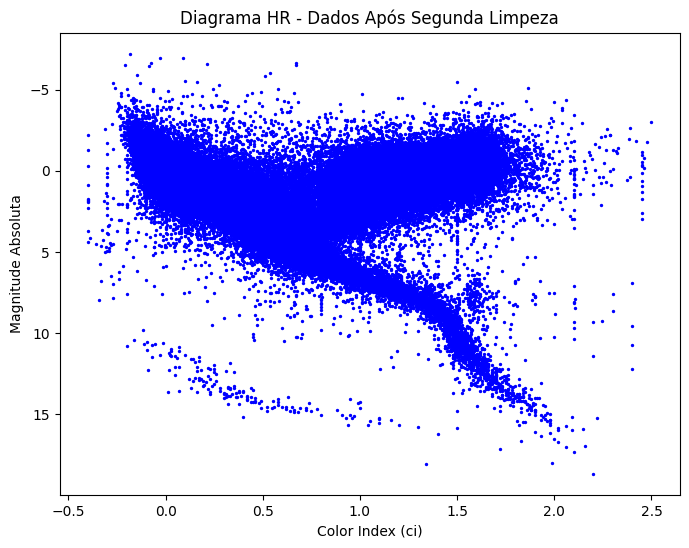

In [10]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Após Segunda Limpeza")
plt.show()


Abaixo, serão calculados o raio estimado para cada estrela, e uma "flag", indicando a faixa de magnitude e cor na qual as estrelas provavelmente são do tipo "anã branca".

In [11]:
# R/Rsun = sqrt(L / (T/Tsun)^4)
Tsun = 5772
df["radius_est"] = np.sqrt(df[col_lum] / ((df[col_temp] / Tsun) ** 4))

# Identificação de anãs brancas
df["white_dwarf_flag"] = (
    (df[col_mag] > 10) &
    (df[col_color] < 0.5)
)

Por fim, antes das análises de clusterização, será selecionada uma amostra do dataframe limpo, considerando 50000 estrelas.

In [12]:
df = df.sample(50000, random_state=56)

Abaixo, são determinadas as cores e classes espectrais de cada estrela, com base em faixas de temperatura, e adicionada uma coluna com o logaritmo da temperatura na base 10.

In [13]:
classes = [0, 3700, 5200, 6000, 7500, 10000, 30000, np.inf]
labels = ["M", "K", "G", "F", "A", "B", "O"]

cores_espectrais = {
    "O": "#4f6cff",
    "B": "#7ea8ff",
    "A": "#dbe9ff",
    "F": "#fff7d6",
    "G": "#ffe86b",
    "K": "#ffb347",
    "M": "#ff5c5c"
}
df["classe_espectral"] = pd.cut(df[col_temp], bins=classes, labels=labels, right=False)

df["log_temp"] = np.log10(df["temp"])
col_temp_log = "log_temp"

Com isso, foram selecionadas as estrelas apresentadas no diagrama HR abaixo para as análises.

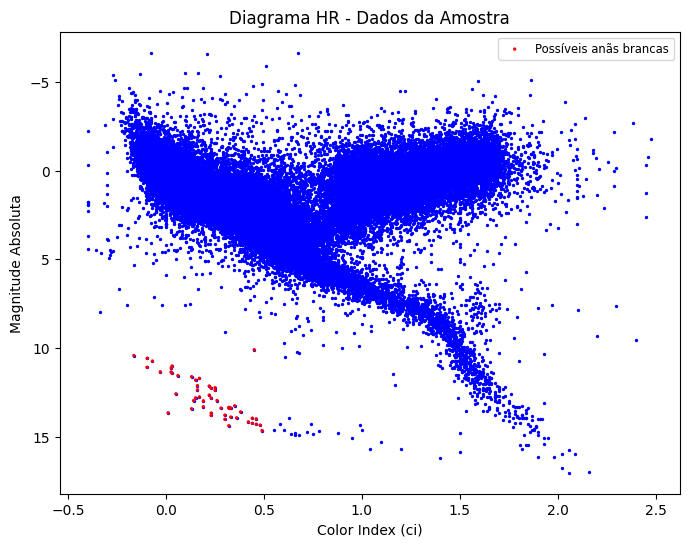

In [14]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

wd = df[df["white_dwarf_flag"]]
plt.scatter(wd[col_color], wd[col_mag],
            edgecolors="red",
            facecolors="none",
            s=2,
            label="Possíveis anãs brancas")

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados da Amostra")
plt.legend(markerscale=1, fontsize="small", loc="best")
plt.show()


# Clustering

## Configurações Iniciais

In [ ]:
# Seleção das variáveis Magnitude Abs. e Log da Temp. para clustering
variaveis = df[[col_mag, col_temp_log]] # 

# Obtenção do Z-score das variáveis
scaler = StandardScaler() # criação da instância que irá definir a nova escala das variáveis
variaveis_s = scaler.fit_transform(variaveis) # aplicação no conjunto de variáveis

In [20]:
def plot_cluster (dados_x, dados_y, clusters, metodo):

    plt.style.use("default")
    
    plt.figure(figsize=(8, 6))

    # Plot dos dados originais coloridos com base no cluster a que pertencem
    for c in np.unique(clusters):
        mask = clusters == c
        plt.scatter(dados_x[mask], dados_y[mask],
                    s=2, alpha=1,
                    label=f"Cluster {c}")

    # Ajustes gerais do plot

    plt.gca().invert_yaxis() # Inverter eixo y
    plt.gca().invert_xaxis() # Inverter eixo x

    plt.xscale("log") # Eixo x na escala log para melhor visualização

    plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
    plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

    plt.title(f"Diagrama HR com Clustering por {metodo}")
    plt.legend(markerscale=1, fontsize="small", loc="best")

    plt.show()

    return

## K-Means

In [21]:
def encontrar_k (dados, k_max): # k_max: maior k a ser incluído na visualização

    plt.style.use("default")

    k_elbow = [] # valores de k para cada valor de inércia correspondente
    k_silhouettes = [] # valores de k para cada silhouette score correspondente
    inertias = [] # valores encontrados para a inércia
    silhouettes = [] # valores encontrados para os silhouette scores

    # Gera silhouette scores e valores de inércia para k de 1 (inércia) ou 2 (silhouette) a k_max
    for k in range (1, k_max + 1): 
        kmeans = KMeans(n_clusters=k, random_state=56) # inicialização da instância de KMeans
        kmeans.fit(dados) # aplicação do processo ao conjunto de dados
        
        k_elbow.append(k) # armazenamento do valor de k atual
        inertias.append(kmeans.inertia_) # cálculo e armazenamento do valor de inércia para o k atual

        if k != 1: # Silhouette Scores só são válidos para k > 1
            score = silhouette_score(dados, kmeans.labels_) # cálculo do silhouette score
            silhouettes.append(score) # armazenamento do silhouette score
            k_silhouettes.append(k) # armazenamento do valor de k atual
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) # criação da figura e dos dois subplots

    # Gráfico do elbow method
    axs[0].plot(k_elbow, inertias, marker="o", linestyle="-")
    axs[0].set_title("Elbow Method")
    axs[0].set_ylabel("Inertia")
    axs[0].set_xlabel("k")

    # Gráfico de silhouette score
    axs[1].plot(k_silhouettes, silhouettes, marker="o", linestyle="-")
    axs[1].set_title("Silhouette Score")
    axs[1].set_ylabel("Score")
    axs[1].set_xlabel("k")

    plt.tight_layout() # reajuste dos subplots para melhor organização dos gráficos
    plt.show() # exibição do gráfico

    return

In [22]:
def visualizar_k (dados_s, dados_x, dados_y, k_min, k_max):

    divisoes = [] # Lista que armazena as classificações para diferentes valores de k

    for k in range(k_min, k_max + 1): # Clustering para k de k_min a k_max

        kmeans = KMeans(n_clusters=k, random_state=42) # criação da instância de KMeans
        kmeans.fit(dados_s) # aplicação do K-Means aos dados
        divisao = kmeans.labels_ # obtenção das classificações dos dados
        divisoes.append(divisao) # armazenamento das classificações
    
    # Plot da figura com os diferentes gráficos distribuídos horizontalmente e com tamanhos iguais

    plt.style.use("dark_background")
    
    fig, axs = plt.subplots(nrows=1, ncols=k_max - k_min + 1, figsize=(5*k_max, 5))

    for i, ax in enumerate(fig.axes, start=1):

        # Plot individual dos gráficos para cada valor de k
        ax.scatter(x=dados_x, y=dados_y, c=divisoes[i - 1], s=2)
        ax.set_title(f"Clustering k = {k_min - 1 + i}")
        ax.set_xscale("log")
        ax.set_xlabel("Temperatura (K)")
        ax.set_ylabel("Magnitude Absoluta")

        ax.invert_xaxis()
        ax.invert_yaxis()


    plt.show()
        
    return

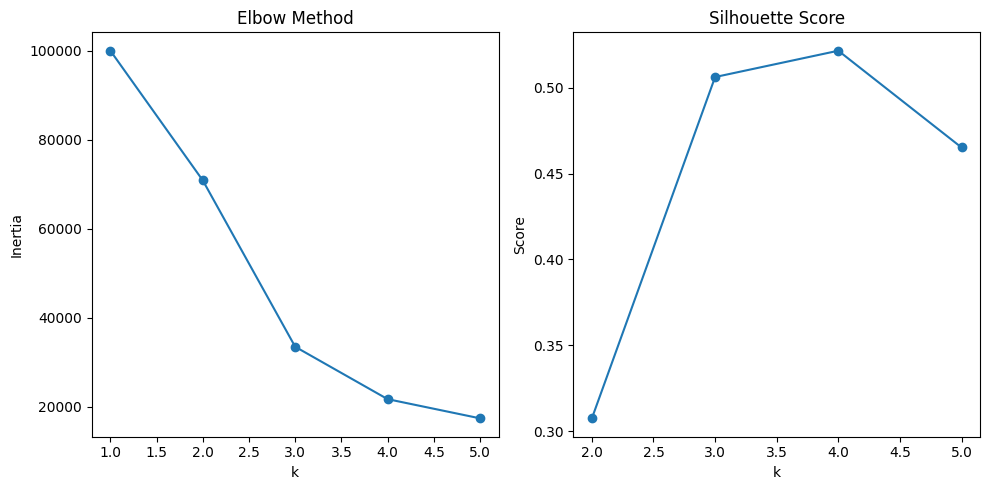

In [21]:
encontrar_k(variaveis_s, 5)

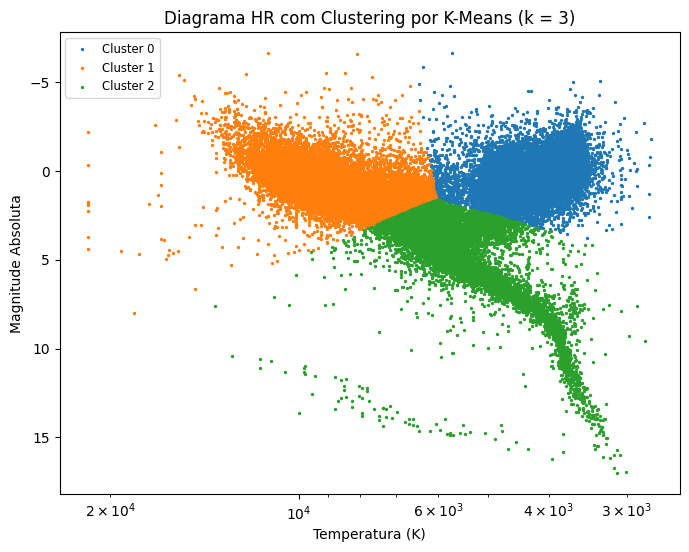

In [23]:
kmeans_3 = KMeans(n_clusters=3, random_state=50) # geração da instância de KMeans referente a k = 3
kmeans_3.fit(variaveis_s) # aplicação da instância aos dados padronizados

plot_cluster (df[col_temp], df[col_mag], kmeans_3.labels_, "K-Means (k = 3)")

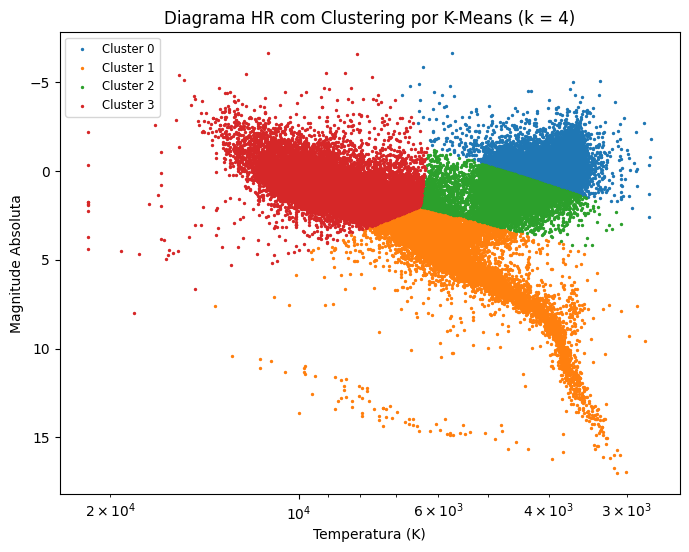

In [24]:
kmeans_4 = KMeans(n_clusters=4, random_state=50) # geração da instância de KMeans referente a k = 4
kmeans_4.fit(variaveis_s) # aplicação da instância aos dados padronizados

plot_cluster (df[col_temp], df[col_mag], kmeans_4.labels_, "K-Means (k = 4)")

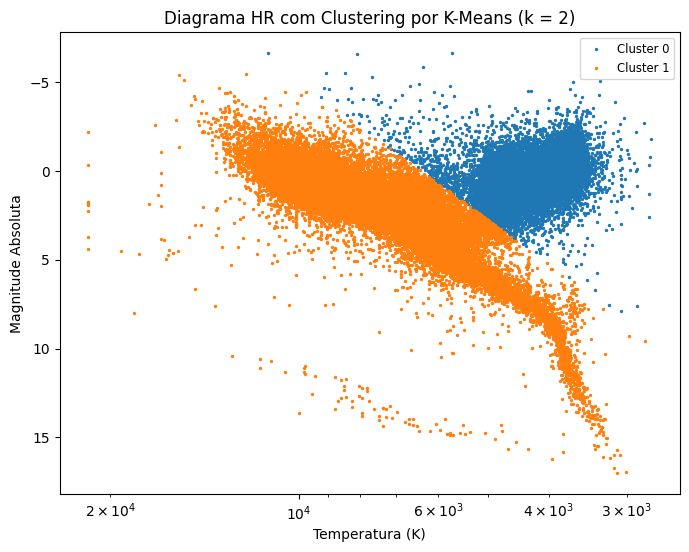

In [25]:
kmeans_2 = KMeans(n_clusters=2, random_state=50) # geração da instância de KMeans referente a k = 4
kmeans_2.fit(variaveis_s) # aplicação da instância aos dados padronizados

plot_cluster (df[col_temp], df[col_mag], kmeans_2.labels_, "K-Means (k = 2)")

## DBSCAN

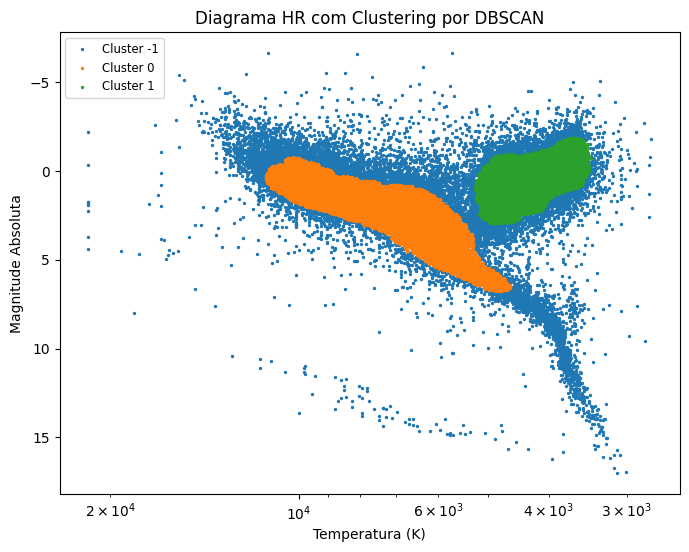

In [26]:
dbscan_modelo = DBSCAN(eps=0.1, min_samples=133).fit(variaveis_s) # criação do modelo para cada combinação
dbscan_labels = dbscan_modelo.labels_ # obtenção da classificação dos dados para cada modelo

df["dbscan"] = dbscan_labels # armazenamento das classificações

plot_cluster (df[col_temp], df[col_mag], df["dbscan"], "DBSCAN")

## GMM

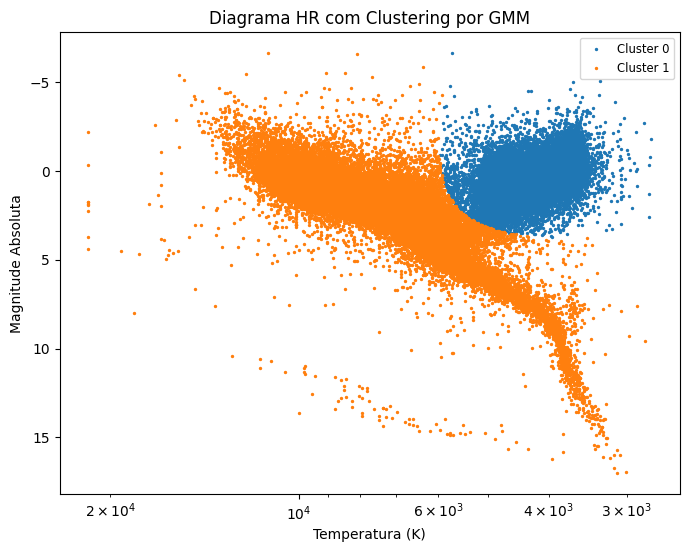

In [27]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=50)
gmm_labels_2 = gmm.fit_predict(variaveis_s)

plot_cluster (df[col_temp], df[col_mag], gmm_labels_2, "GMM")


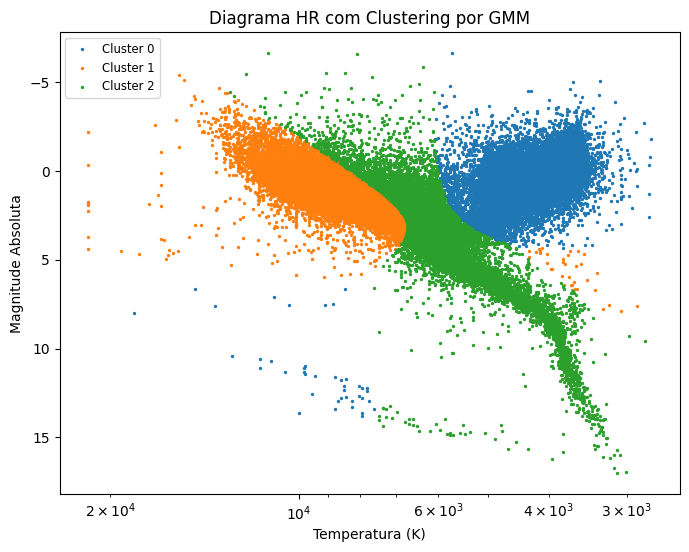

In [28]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=50)
gmm_labels_3 = gmm.fit_predict(variaveis_s)

plot_cluster (df[col_temp], df[col_mag], gmm_labels_3, "GMM")

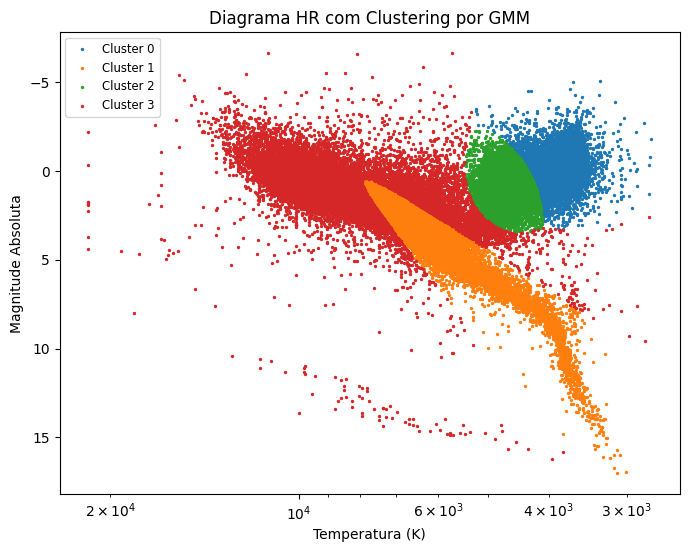

In [29]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=50)
gmm_labels_4 = gmm.fit_predict(variaveis_s)

plot_cluster (df[col_temp], df[col_mag], gmm_labels_4, "GMM")

## HDBSCAN

In [91]:
min_cluster_size = 200

cluster_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
df["hdbscan"] = cluster_hdbscan.fit_predict(variaveis_s)

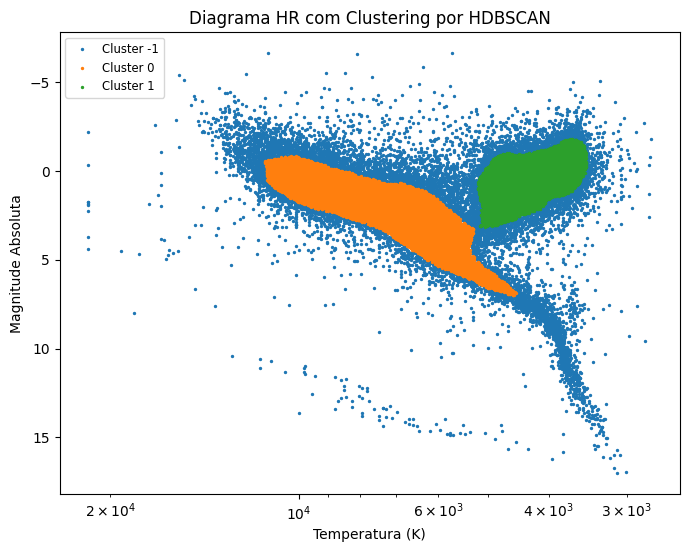

In [92]:
plot_cluster (df[col_temp], df[col_mag], df["hdbscan"], "HDBSCAN")

## Conclusões

# Análise de Dados - Diagrama HR

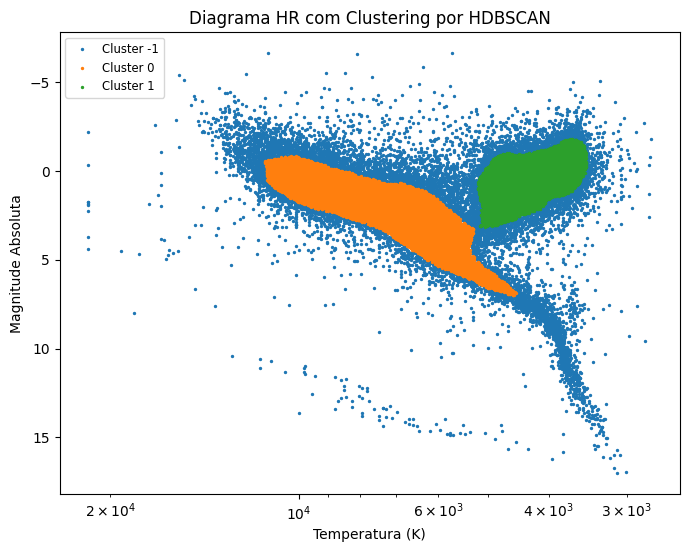

In [93]:
plot_cluster (df[col_temp], df[col_mag], df["hdbscan"], "HDBSCAN")

In [94]:
df["clusters"] = df["hdbscan"]
df.loc[df["white_dwarf_flag"] == True, "clusters"] = 2

df_sem_ruido = df[df["clusters"] != -1].copy()

In [95]:
df_sem_ruido["clusters"].unique()

array([0, 1, 2])

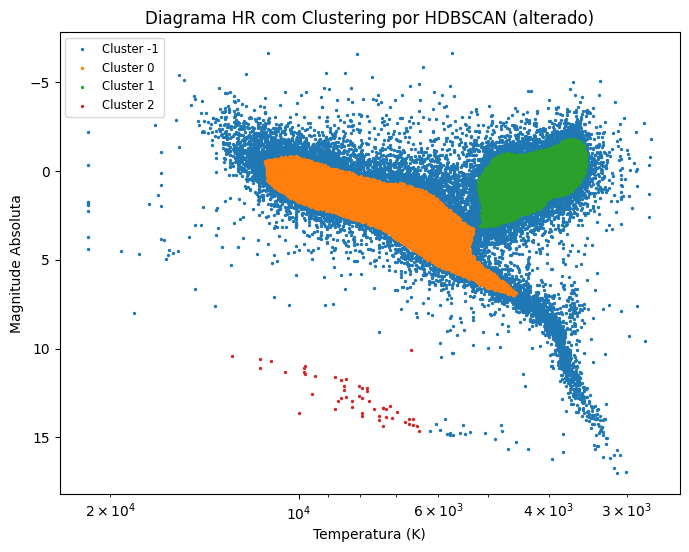

In [96]:
plot_cluster (df[col_temp], df[col_mag], df["clusters"], "HDBSCAN (alterado)")

## Análises por Cluster

In [97]:
ordem_espectral = {
    "O": 0,
    "B": 1,
    "A": 2,
    "F": 3,
    "G": 4,
    "K": 5,
    "M": 6
}

df_sem_ruido["ordem_espectral"] = df_sem_ruido["classe_espectral"].map(ordem_espectral)

In [98]:
labels = ["M", "K", "G", "F", "A", "B", "O"]

hist_classe_spec = alt.Chart(df_sem_ruido).transform_joinaggregate(
    total='count()',
    groupby=['clusters']
).transform_calculate(
    percent='1 / datum.total'
).mark_bar(size=60).encode(
    x=alt.X(
        "clusters:N",
        title="Clusters",
        axis=alt.Axis(labelAngle=0),
        scale=alt.Scale(paddingInner=0.6)
    ),

    y=alt.Y(
        "sum(percent):Q",
        stack="zero",
        title="Frequência (%)",
        axis=alt.Axis(format="%")
    ),

    order=alt.Order(
    "ordem_espectral:Q",
    sort="descending"
),

color=alt.Color(
    "classe_espectral:N",
    title="Classes Espectrais",
    scale=alt.Scale(
        domain=["O","B","A","F","G","K","M"],
        range=[cores_espectrais[c] for c in ["O","B","A","F","G","K","M"]]
    )
    ),
    tooltip=[
        alt.Tooltip("classe_espectral:N", title="Classe Espectral"),
        alt.Tooltip("clusters:Q", title="Cluster"),
        alt.Tooltip("sum(percent):Q", format=".2%", title="Porcentagem"),
        alt.Tooltip("count():Q", title="Frequência")
    ]
).properties(
    height=450,
    width=500,
    title="Histograma de Classes Espectrais por Clusters"
).interactive()

In [ ]:
hist_classe_spec

Obs: teoricamente anãs brancas têm uma classificação separada (D), mas o diagrama acima serve para comparar com as cores das classes espectrais padrão, indicando faixa de temperatura e cor.

In [ ]:
def boxplot_por_cluster(dados, var_y, nome_y, titulo, inv_y=False, log_y=False):
    lista = ["G", "M", "A"]
    cores = [cores_espectrais[classe] for classe in lista]

    if log_y:
        escala_y = alt.Scale(type="log", reverse=inv_y)
    else:
        escala_y = alt.Scale(reverse=inv_y)

    box = alt.Chart(dados).mark_boxplot(
        size=60
    ).encode(
        x=alt.X(
            "clusters:N",
            title="Cluster",
            axis=alt.Axis(labelAngle=0)
        ),
        y=alt.Y(
            f"{var_y}:Q",
            title=nome_y,
            scale=escala_y
        ),
        color=alt.Color(
            "clusters:O",
            title="Cluster",
            scale=alt.Scale(range=cores),
            legend=None
        ),
        tooltip=[
            alt.Tooltip(f"{var_y}:Q", title=nome_y)
        ]
    ).properties(
        width=500,
        height=450,
        title=f"{titulo}"
    )
    return box

In [101]:
boxplot_temp = boxplot_por_cluster(df_sem_ruido, "temp", "Temperatura (K)", "Distribuição de Temperaturas por Cluster")
boxplot_absmag = boxplot_por_cluster(df_sem_ruido, "absmag", "Magnitude Absoluta", "Distribuição de Magnitudes Absolutas por Cluster", inv_y=True)
boxplot_dist = boxplot_por_cluster(df_sem_ruido, "dist", "Distância (ly)", "Distribuição de Distâncias por Cluster")
boxplot_raio = boxplot_por_cluster(df_sem_ruido, "radius_est", "Raio (x Raio Solar)", "Distribuição de Raios por Cluster", log_y=False)
boxplot_raio_log = boxplot_por_cluster(df_sem_ruido, "radius_est", "Raio (x Raio Solar)", "Distribuição de Raios por Cluster", log_y=True)

In [ ]:
boxplot_temp

In [ ]:
boxplot_absmag

In [ ]:
# ==========================
# 1️⃣ Calcular estatísticas
# ==========================

stats = (
    df_sem_ruido.groupby("clusters")["radius_est"]
      .quantile([0.25, 0.5, 0.75])
      .unstack()
      .reset_index()
)

stats.columns = ["clusters", "Q1", "Mediana", "Q3"]

# ==========================
# 2️⃣ Transformar para formato long
# ==========================

stats_long = stats.melt(
    id_vars="clusters",
    var_name="quartile",
    value_name="radius_est"
)

# ==========================
# 3️⃣ Criar posição horizontal fixa
# ==========================

# deslocar clusters no eixo x
stats_long["x_pos"] = stats_long["clusters"]

# posição vertical fixa
stats_long["y_pos"] = 0

# ==========================
# 4️⃣ Criar gráfico
# ==========================

chart = alt.Chart(stats_long).mark_point(
    filled=False,        # 👈 só contorno
    strokeWidth=2
).encode(
    x=alt.X("x_pos:O", title="Cluster"),
    y=alt.Y("y_pos:Q", axis=None),
    size=alt.Size(
        "radius_est:Q",
        title = "Escala de Raio",
        scale=alt.Scale(range=[200, 12000])  # ajuste fino aqui
    ),
    color=alt.Color("quartile:N", legend=alt.Legend(title="Quartil")),
    order=alt.Order("radius_est:Q", sort="descending"),
    tooltip=[
        alt.Tooltip("clusters:Q", title="Cluster"),
        alt.Tooltip("quartile:N", title="Tipo"),
        alt.Tooltip("radius_est:Q", title="Raio", format=".2f")
    ]
).properties(
    width=500,
    height=400,
    title = "Distribuição de Raios por Cluster"
)

chart

In [ ]:
boxplot_raio

In [ ]:
boxplot_raio_log

No boxplot acima, é possível observar que as estrelas do tipo 0 possuem raios muito maiores que as estrelas de outros clusters, enquanto estrelas do tipo 2 possuem raios muito menores.

In [ ]:
boxplot_dist

No boxplot acima, é possível observar um viés importante para explicar a baixa quantidade de anãs brancas no dataset. Além da relativa raridade, não foram identificadas estrelas deste tipo a partir de determinada distância, o que pode ser explicado também considerando a baixa luminosidade e o raio pequeno, que as torna difíceis de identificar.

# Construção do Diagrama HR

In [119]:
dfp = df.sample(10000, random_state=56)

## HDBSCAN

### Gráfico 01 - Tamanho dependente do Raio

In [120]:
r = dfp[col_raio]

# corta outliers
r_clip = r.clip(r.quantile(0.05), r.quantile(0.95))

# normaliza tamanho
s_min, s_max = 5, 60
s = s_min + (r_clip - r_clip.min())/(r_clip.max() - r_clip.min()) * (s_max - s_min)

In [121]:
cores = {
    -1: "gray",     # ruído
     0: "red",
     1: "yellow",
     2: "blue"
}

c = dfp["clusters"].map(cores)

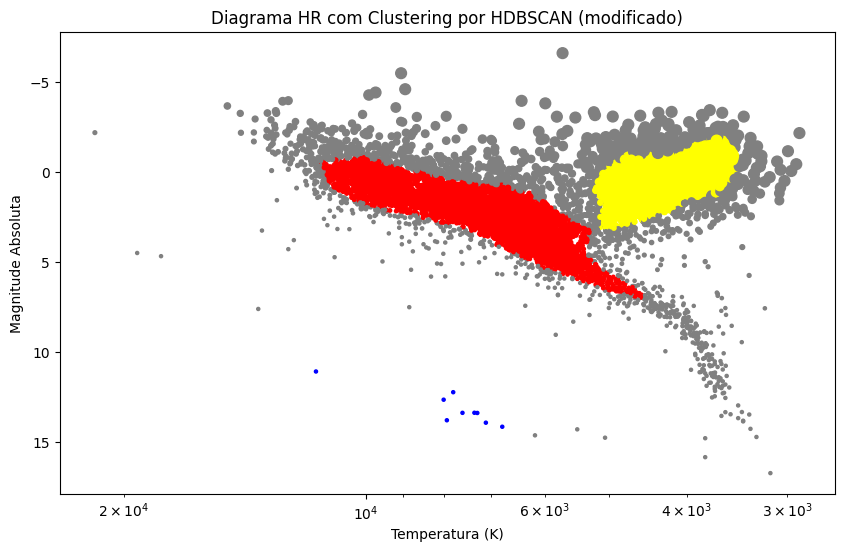

In [168]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por HDBSCAN (modificado)")

plt.show()

### Gráfico 02 - Adição de Contornos

In [171]:
def desenhar_elipse(x, y, ax, n_std=3.5, **kwargs):
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)

    # autovalores e autovetores
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # ângulo da elipse
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # largura e altura (raiz dos autovalores)
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse((mean_x, mean_y),
                      width=width, height=height,
                      angle=theta,
                      fill=False,
                      **kwargs)

    ax.add_patch(ellipse)

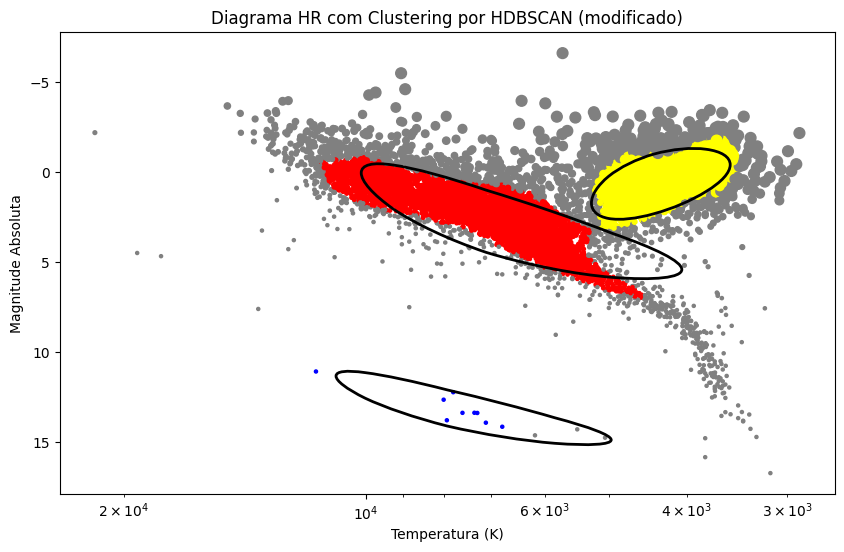

In [172]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=c)

for cl in sorted(dfp["clusters"].unique()):
    if cl == -1:
        continue  # ignora ruído

    subset = dfp[dfp["clusters"] == cl]

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.1, edgecolor="black", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log")

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

plt.title(f"Diagrama HR com Clustering por HDBSCAN (modificado)")

plt.show()

### Gráfico 03 - Classes Espectrais

In [173]:
dfp["cor_espectral"] = dfp["classe_espectral"].map(cores_espectrais)

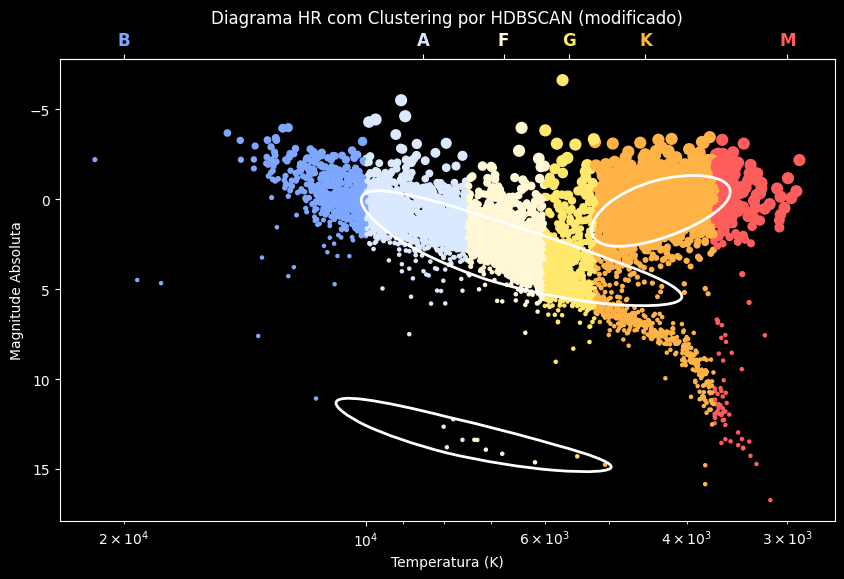

In [174]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["clusters"].unique()):
    if cl == -1:
        continue  # ignora ruído

    subset = dfp[dfp["clusters"] == cl]

    if cl == 2:
        desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.1, edgecolor="white", linewidth=2)
        
        continue

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.1, edgecolor="white", linewidth=2)

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por HDBSCAN (modificado)")

plt.show()

### Gráfico 04 - Retas com Raios

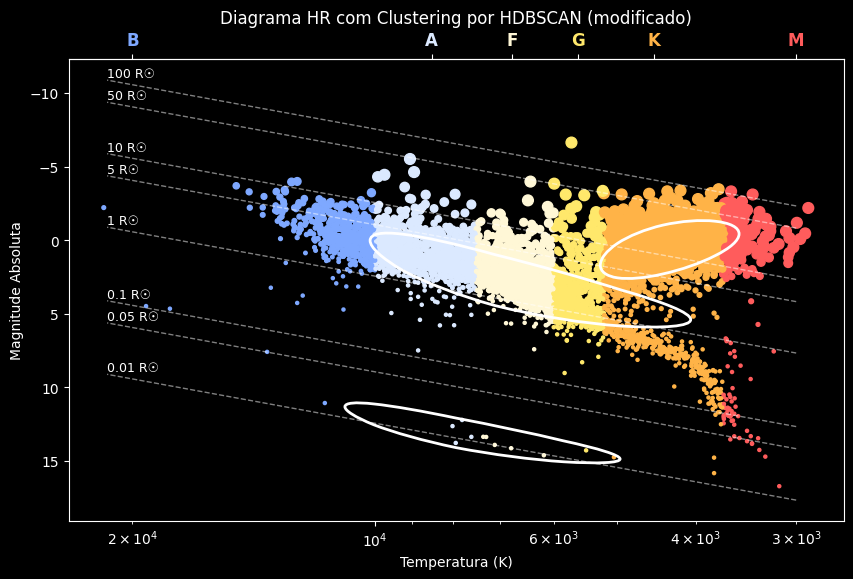

In [175]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

for cl in sorted(dfp["clusters"].unique()):
    if cl == -1:
        continue  # ignora ruído

    subset = dfp[dfp["clusters"] == cl]

    if cl == 2:
        desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.1, edgecolor="white", linewidth=2)
        
        continue

    desenhar_elipse(subset[col_temp], subset[col_mag], ax,
                    n_std=2.1, edgecolor="white", linewidth=2)

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR com Clustering por HDBSCAN (modificado)")

plt.show()

## Classes Espectrais

### Sem Raios

C:\Users\marce\AppData\Local\Temp\ipykernel_25876\4033277768.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


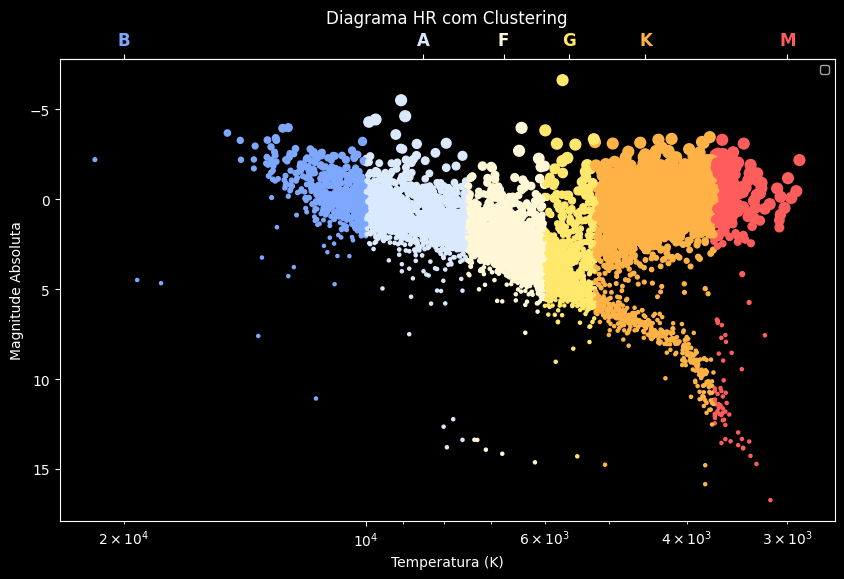

In [ ]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()

### Retas com Raios

C:\Users\marce\AppData\Local\Temp\ipykernel_25876\440973464.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=1, fontsize="small", loc="best")


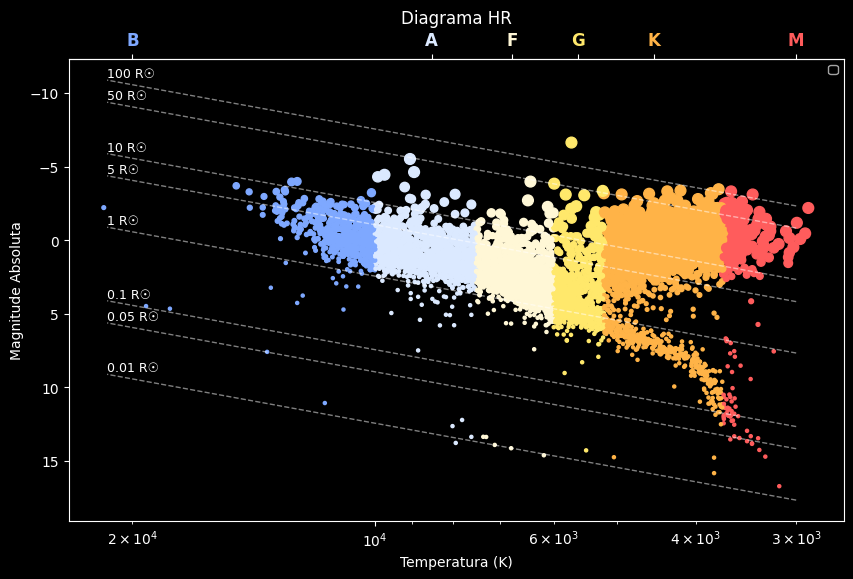

In [178]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter (dfp[col_temp], dfp[col_mag], s=s, alpha=1, c=dfp["cor_espectral"])

T_sun = 5777
M_sun = 4.83

# intervalo de temperatura do seu gráfico
T_vals = np.logspace(np.log10(3000), np.log10(21500), 500)

raios = [0.01, 0.05, 0.1, 1, 5, 10, 50, 100]

for R in raios:
    M_vals = (
        M_sun
        - 5*np.log10(R)
        - 10*np.log10(T_vals / T_sun)
    )

    ax.plot(T_vals, M_vals, linestyle="--", linewidth=1, color="white", alpha=0.5)

    # rótulo perto da borda direita
    ax.text(
        T_vals[-1],
        M_vals[-1],
        f"{R} R☉",
        fontsize=9,
        verticalalignment='bottom'
    )

# Ajustes gerais do plot

plt.gca().invert_yaxis() # Inverter eixo y
plt.gca().invert_xaxis() # Inverter eixo x

plt.xscale("log") # Eixo x na escala log para melhor visualização

plt.xlabel("Temperatura (K)") # Eixo x equivalente ao eixo da temperatura
plt.ylabel("Magnitude Absoluta") # Eixo y equivalente ao eixo da magnitude absoluta

# eixo superior
ax_top = ax.secondary_xaxis('top')

ticks_temp = [40000, 20000, 8500, 6750, 5600, 4500, 3000]
labels = ["O", "B", "A", "F", "G", "K", "M"]

ax_top.set_xticks(ticks_temp)
ax_top.set_xticklabels(labels)

# colorir os rótulos
for tick, label in zip(ax_top.get_xticklabels(), labels):
    tick.set_color(cores_espectrais[label])
    tick.set_fontsize(12)
    tick.set_fontweight("bold")

ax_top.tick_params(which='minor', top=False)
ax_top.minorticks_off()

plt.title(f"Diagrama HR")
plt.legend(markerscale=1, fontsize="small", loc="best")

plt.show()